In [85]:
import requests
import pandas as pd
from flatten_json import flatten
from utils.io import dict_to_yaml
from utils.io import yaml_to_dict
import numpy as np
from typing import List, Tuple, Dict, Union
from itertools import compress
import pandas as pd
import re
import datetime as dt
from cleanco import basename
from json import dumps
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join

# from projects.lobbying.postproc import terms_present
import matplotlib.colors as mc

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [137]:
# df.to_csv("~/Desktop/postprocessed_ccs.csv")

df = pd.read_csv("~/Desktop/postprocessed_ccs.csv")

In [140]:
df.contains_ccs_description = [
    1 if (x == "1") | (x == "True") else 0 for x in df.contains_ccs_description
]

In [143]:
for i, row in df.loc[
    (df.contains_ccs_description == 0) & (df.very_likely_ccs == 1)
].iterrows():
    print(f'{row["client_rename"]}: {row["clean_description"]}')

JUPITER OXYGEN: HR 6 Energy Policy Act of 2005 research and development issues HR 2419 Energy and Water Development Appropriations Act 2006 research and development issues
JUPITER OXYGEN: HR 6 Energy Policy Act of 2005 research and development issues HR 2419 Energy and Water Development Appropriations Act 2006 research and development issues
JUPITER OXYGEN: HR 6 Energy Policy Act of 2005 research and development issues HR 2419 Energy and Water Development Appropriations Act 2006 research and development issues
JUPITER OXYGEN: HR6 Energy Policy Act of 2005 research and development issues HR2419 Energy and Water Development Appropriations Act research and development issues
JUPITER OXYGEN: HR6 Energy Policy Act of 2005 research and development issues HR2419 Energy and Water Development Appropriations Act research and development issues
JUPITER OXYGEN: HR6 Energy Policy Act of 2005 research and development issues HR2419 Energy and Water Development Act of 2005 research and development iss

In [4]:
df = pd.read_csv(
    "/Volumes/Samsung_T5/data/lobbying/ccs_lda_filings/postprocessed_ccs.csv"
)


In [144]:
df = df.loc[df.very_likely_ccs == 1]

tot_dollars = df.lobbying_activity_usd.sum()

tot_contacts = df.n_entities_lobbied.sum()

df["pct_of_lobbying_dollars"] = [
    100 * x / tot_dollars for x in df.lobbying_activity_usd
]

df["pct_of_entity_contacts"] = [100 * x / tot_contacts for x in df.n_entities_lobbied]

In [145]:
lobbying_by_sector_totals_df = (
    df[
        [
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "pct_of_lobbying_dollars",
            "pct_of_entity_contacts",
        ]
    ]
    .loc[df["very_likely_ccs"] == 1]
    .groupby(["sector"])
    .agg(
        {
            "lumped_sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
            "pct_of_lobbying_dollars": sum,
            "pct_of_entity_contacts": sum,
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)


lobbying_by_sector_totals_df.to_clipboard()

In [146]:
def terms_present(phrase, term_list, find_any=True):
    """utility function to see if terms in terms_list are present in a given phrase
    Args:
        phrase: phrase to be searched
        term_list: list of strings to be searched for within phrase
        find_any: boolean -- true if function should return true if any of the terms are in the phrase;
            false if the function should only return true if all terms are present
    Returns:
        int: 1 if one or more of the terms are present in phrase, 0 otherwise
    """
    if not isinstance(phrase, str):
        raise TypeError("phrase must be a string")
    if not isinstance(term_list, list):
        raise TypeError(
            "term_list must be a list of strings (even if it is a list of length 1)"
        )
    if phrase is None:
        return 0
    n_present = 0

    for term in term_list:
        if isinstance(term, list):
            if terms_present(phrase, term, find_any=False):
                if find_any:
                    return 1
                n_present += 1
        elif term.lower() in phrase.lower():
            if find_any:
                return 1
            n_present += 1
    if n_present == len(term_list):
        return 1
    return 0


def substitute(
    x: str,
    use_basename: bool = False,
    re_types: str = r"[^\w\s]",
    replace_str: str = "",
):
    """wrapper function for regular expression substitute funciton, linked with basename lib"""
    # use basename for company names
    if not isinstance(x, str):
        x = ""
    if use_basename:
        return basename(re.sub(re_types, replace_str, x))
    # don't use basename for general strings
    return re.sub(re_types, replace_str, x).rstrip().lstrip()

In [147]:
# from postprocess_ccs import get_ccs_bills

ccs_bills = yaml_to_dict("ccs_laws.yml")["contains_ccs_provisions"]
ccs_bills = [substitute(x, use_basename=False) for x in ccs_bills]

In [148]:
df["bill_contains_ccs_provisions"] = [
    1 if terms_present(x, ccs_bills) else 0 for x in df.clean_description
]

In [149]:
def quarter_to_decimal(q: str) -> float:
    """converts string quarter to decimal fraction of year"""
    if q == "second_quarter":
        return 135 / 365.25
    if q == "third_quarter":
        return 227 / 365.25
    if q == "first_quarter":
        return 46 / 365.25
    if q == "fourth_quarter":
        return 319 / 365.25
    if q == "year_end":
        return 274 / 265.25
    if q == "mid_year":
        return 91 / 365.25
    raise ValueError("%s quarter string is not one of accepted strings.", q)

In [150]:
df["decimal_filing_year"] = [
    float(y) + quarter_to_decimal(q) for y, q in zip(df.filing_year, df.filing_period)
]

In [151]:
# merge client states
df.loc[df.client_state != df.client_ppb_state].client_state.value_counts(dropna=False)
df["client_state_merged"] = df.client_state.fillna(df["client_ppb_state"])

In [162]:
names = df.loc[df.sector == "environmental"].client_rename.unique()
for name in names:
    original_names = list(df.loc[df.client_rename == name].client_name.unique())
    for o in original_names:
        print(f"{o}: {name}")

NATIONAL PARKS CONSERVATION ASSOCIATION: NATIONAL PARKS CONSERVATION ASSOCIATION
SIERRA CLUB: SIERRA CLUB
TRUST FOR PUBLIC LAND: TRUST FOR PUBLIC LAND
GREENPEACE, INC: GREENPEACE
NATIONAL GROUND WATER ASSOCIATION: NATIONAL GROUND WATER ASSOCIATION
ENVIRONMENTAL DEFENSE ACTION FUND: ENVIRONMENTAL DEFENSE FUND
ENVIRONMENTAL DEFENSE FUND, INCORPORATED: ENVIRONMENTAL DEFENSE FUND
CLEAN AIR TASK FORCE: CLEAN AIR TASK FORCE
CATF ACTION, INC.: CLEAN AIR TASK FORCE
AJW ON BEHALF OF CLEAN AIR TASK FORCE: CLEAN AIR TASK FORCE
FRIENDS OF THE EARTH: FRIENDS OF EARTH
LAND TRUST ALLIANCE: LAND TRUST ALLIANCE
WESTERN ORGANIZATION OF RESOURCE COUNCILS: WESTERN ORGANIZATION OF RESOURCE COUNCILS
GEOS INSTITUTE (FORMERLY NATIONAL CENTER FOR CONSERVATION SCIENCE): GEOS INSTITUTE
OPEN SPACE INSTITUTE, INC.: OPEN SPACE INSTITUTE
THE WILDERNESS SOCIETY: WILDERNESS SOCIETY
EARTHJUSTICE: EARTHJUSTICE
LEAGUE OF CONSERVATION VOTERS: LEAGUE OF CONSERVATION VOTERS
BLUE GREEN ALLIANCE: BLUE GREEN ALLIANCE
NATURAL R

In [188]:
univ_df = pd.read_csv("university_with_rename.csv", index_col=[0])
univ_df.institution_name = [x.upper() for x in univ_df.institution_name]
univ_df.to_csv("university_with_rename.csv")

In [190]:
ccs_univ_df = (
    df[["client_rename", "lobbying_activity_usd"]]
    .loc[df.sector == "higher education"]
    .groupby(["client_rename"])
    .sum()
    .sort_values(by=["lobbying_activity_usd"], ascending=False)
)
univ_df.merge(
    ccs_univ_df, right_index=True, left_on="institution_name", how="outer"
).sort_values(by="total_og_funding_2010_to_2020", ascending=False)

,institution_name,total_og_funding_2010_to_2020,lobbying_activity_usd
20.0,UNIVERSITY OF CALIFORNIA,154302577.0,36382.978723
22.0,UNIVERSITY OF ILLINOIS,108221802.0,87841.269841
6.0,GEORGE MASON UNIVERSITY,63935218.0,NaN
18.0,STANFORD UNIVERSITY,56622194.0,NaN
24.0,UNIVERSITY OF TEXAS AT AUSTIN,45421866.0,17500.000000
13.0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,40475798.0,26156.285714
16.0,PRINCETON UNIVERSITY,36096163.0,NaN
17.0,RICE UNIVERSITY,27681709.0,33642.857143
19.0,TEXAS A&M UNIVERSITY,26490970.0,NaN
10.0,HARVARD UNIVERSITY,21142825.0,NaN


In [184]:
univ_df.sort_values(by="total_og_funding_2010_to_2020", ascending=False)

,institution_name,total_og_funding_2010_to_2020
20,UNIVERSITY OF CALIFORNIA BERKELEY,154302577
22,UNIVERSITY OF ILLINOIS AT URBANA-CHAMPAIGN,108221802
6,GEORGE MASON UNIVERSITY,63935218
18,STANFORD UNIVERSITY,56622194
24,UNIVERSITY OF TEXAS AT AUSTIN,45421866
13,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,40475798
16,PRINCETON UNIVERSITY,36096163
17,RICE UNIVERSITY,27681709
19,TEXAS A&M UNIVERSITY,26490970
10,HARVARD UNIVERSITY,21142825


In [193]:
df[["filing_year", "client_rename", "lobbying_activity_usd"]].loc[
    df.sector == "think tanks and issue advocacy"
].groupby(["filing_year", "client_rename"]).sum().sort_values(
    by=["filing_year", "lobbying_activity_usd"], ascending=False
).head(
    60
)

lobbying_activity_usd
filing_year client_rename                                                            
2024        BIPARTISAN POLICY CENTER                                     1.210000e+05
            CENTER FOR TRANSPORTATION AND ENVIRONMENT                    2.000000e+04
2023        BIPARTISAN POLICY CENTER                                     2.591558e+05
            CENTER FOR TRANSPORTATION AND ENVIRONMENT                    4.000000e+04
2022        BIPARTISAN POLICY CENTER                                     2.656926e+05
            ASSOCIATION FOR IMPROVEMENT OF AMERICAN INFRAST...           1.904762e+04
2021        BIPARTISAN POLICY CENTER                                     2.819355e+05
2019        ENERGY FORWARD                                               3.200000e+05
            BIPARTISAN POLICY CENTER                                     6.003344e+04
2018        ENERGY FORWARD                                               6.400000e+05
            BIPARTISAN POLICY CENTER                                     9.000000e+04
2017        ENERGY FORWARD                                               7.000000e+05
            CENTER FOR INDIVIDUAL FREEDOM                                1.040000e+03
            AMERICAN CONSERVATIVE UNION                                  7.692308e+02
2016        ENERGY FORWARD                                               8.600000e+05
            TAXPAYERS FOR COMMON SENSE                                   0.000000e+00
2015        ENERGY FORWARD                                               1.220000e+06
            TAXPAYERS FOR COMMON SENSE                                   0.000000e+00
2014        ENERGY FORWARD                                               1.080000e+06
2013        ENERGY FORWARD                                               2.700000e+05
2007        AMERICANS FOR TAX REFORM                                     4.975000e+04
            CENTER FOR AMERICAN PROGRESS                                 1.285714e+04

Text(0.5, 0, '')

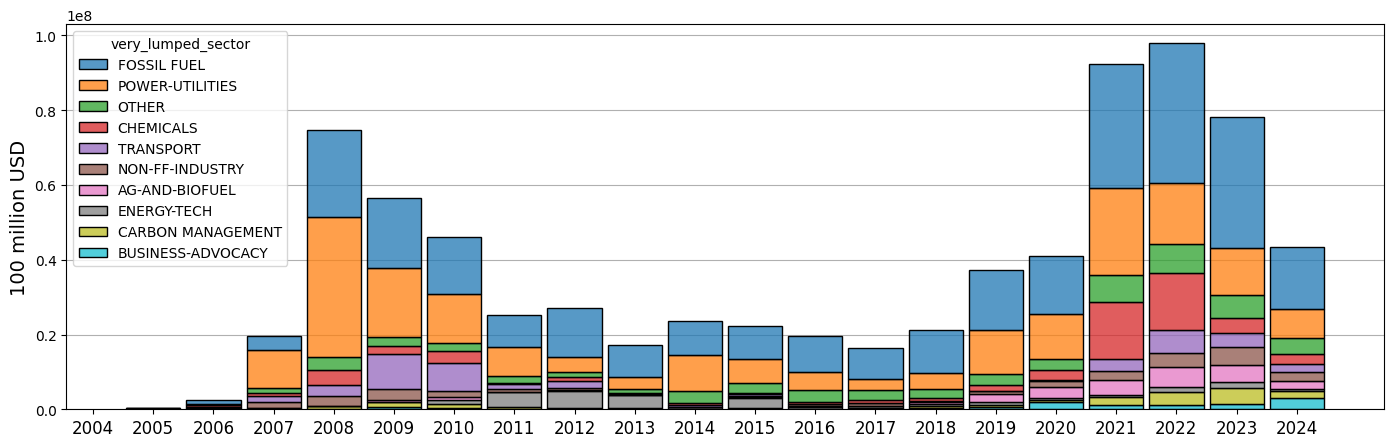

In [157]:
# for histogram hue ordering:
sector_for_group = "very_lumped_sector"
very_lumped_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.very_likely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue=sector_for_group,
    hue_order=very_lumped_order,
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")a

<Axes: xlabel='decimal_filing_year', ylabel='lobbying_activity_usd'>

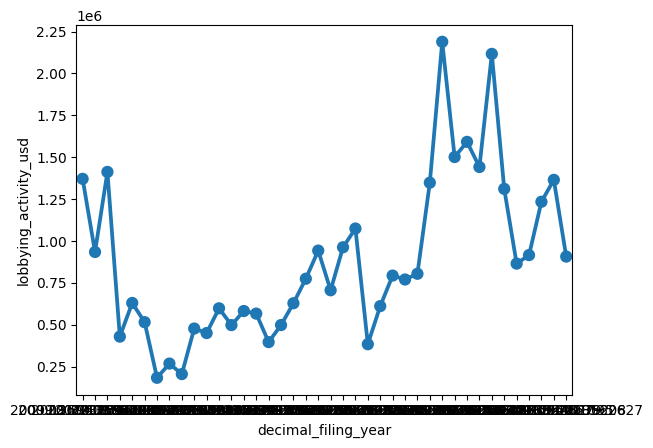

In [130]:
tmp_df = (
    df[
        [
            "filing_year",
            "filing_period",
            "decimal_filing_year",
            "n_entities_lobbied",
            "lobbying_activity_usd",
        ]
    ]
    .loc[df.client_rename == "EXXON"]
    .groupby(["filing_year", "filing_period"])
    .agg(
        {
            "decimal_filing_year": "mean",
            "n_entities_lobbied": sum,
            "lobbying_activity_usd": sum,
        }
    )
    .reset_index()
    .sort_values(by="decimal_filing_year", ascending=True)
)
sns.pointp
lot(data=tmp_df, x="decimal_filing_year", y="lobbying_activity_usd")

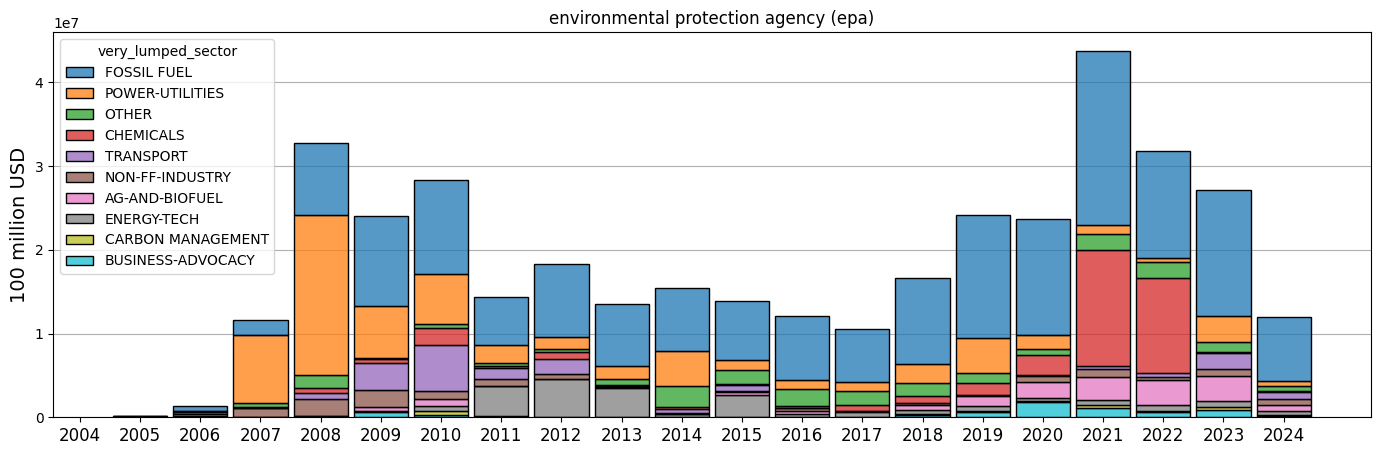

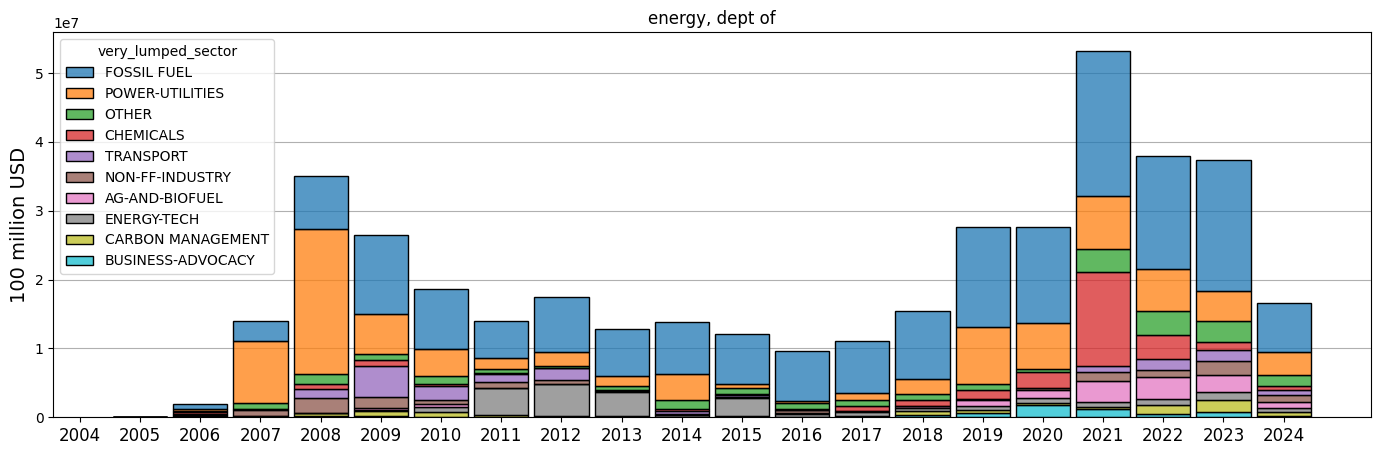

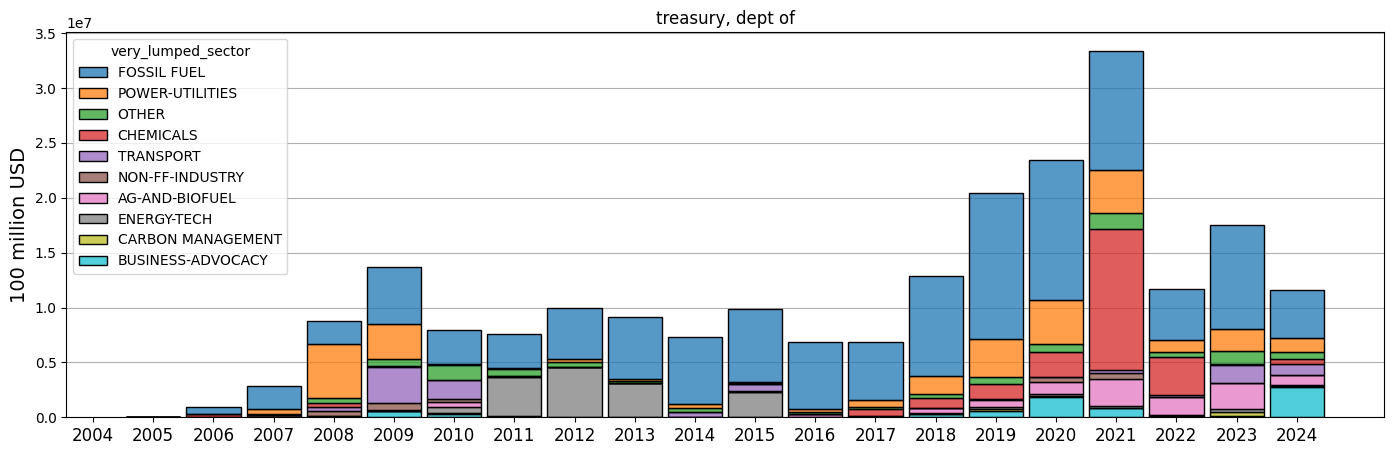

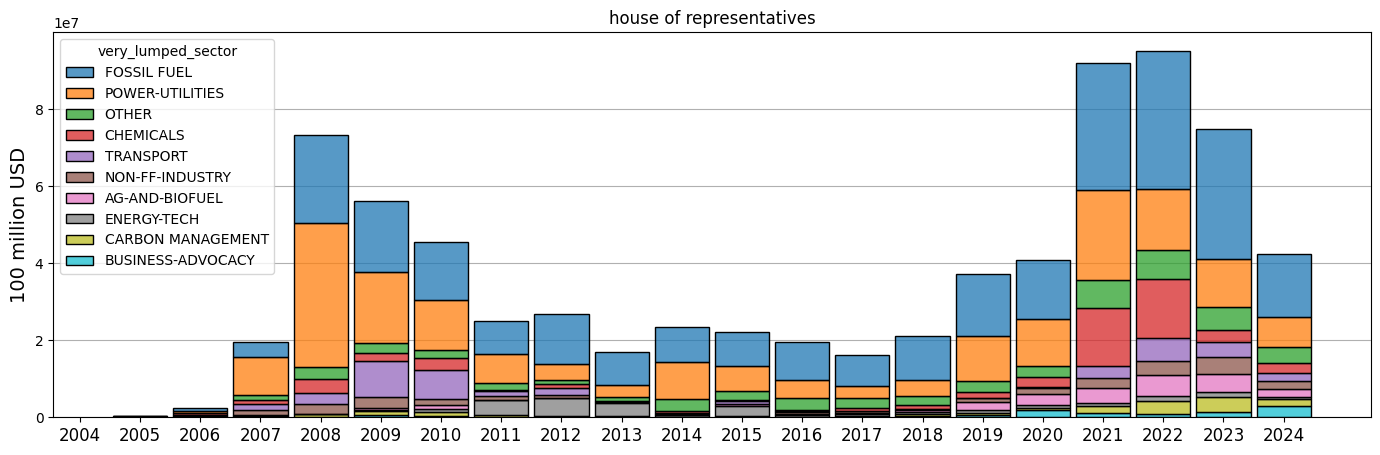

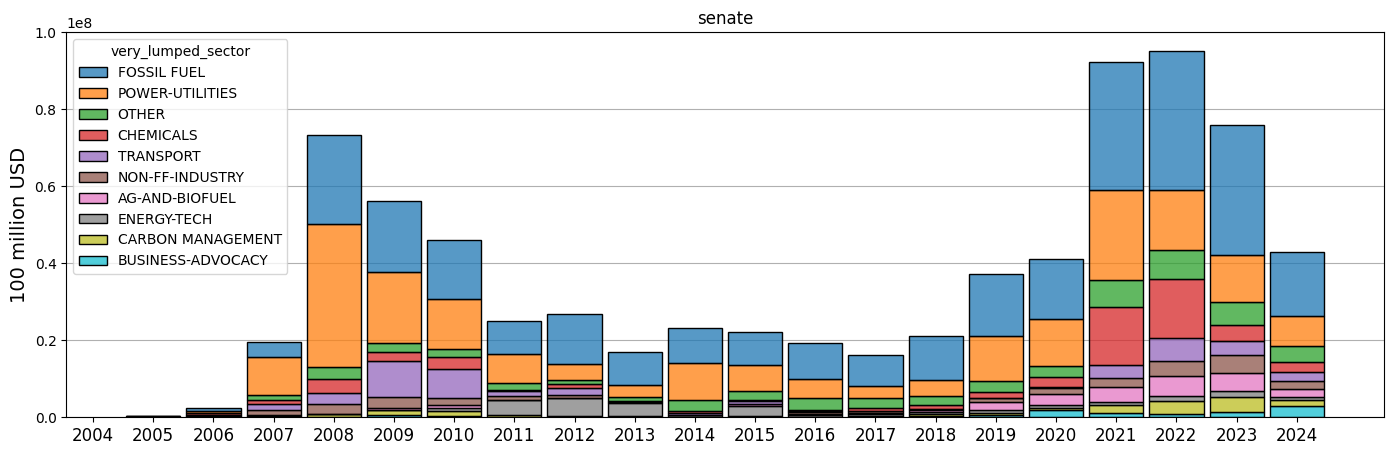

In [78]:
# lobbying_activity_usd
years = list(range(2004, 2025))
for agency in [
    "environmental protection agency (epa)",
    "energy, dept of",
    "treasury, dept of",
    "house of representatives",
    "senate",
]:
    tmp_df = (
        df[["filing_year", "lobbying_activity_usd", "very_lumped_sector"]]
        .loc[(df.very_likely_ccs == 1) & (df[agency] == 1)]
        .groupby(["very_lumped_sector", "filing_year"])
        .sum()
        .sort_values(by="lobbying_activity_usd", ascending=False)
        .reset_index()
    ).copy(deep=True)
    fig, ax = plt.subplots(1, 1, figsize=(17, 5))
    ax = sns.histplot(
        data=tmp_df,
        x="filing_year",
        bins=[0.5 + x for x in years],
        hue="very_lumped_sector",
        hue_order=very_lumped_order,
        shrink=0.9,
        weights="lobbying_activity_usd",
        multiple="stack",
    )
    ax.set_xticks(years)
    ax.set_xticklabels([str(x) for x in years], fontsize=12)
    ax.set_axisbelow(True)
    ax.yaxis.grid()
    ax.set_ylabel("100 million USD", fontsize=14)
    ax.set_xlabel("")
    ax.set_title(agency)
    # ax.legend(ncols=3, loc="upper center")a

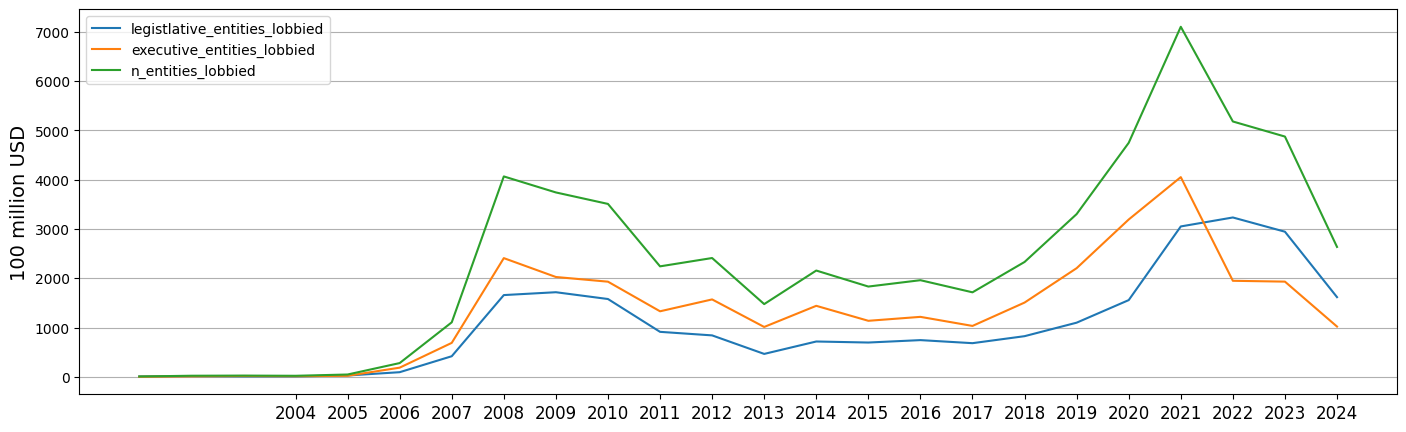

In [83]:
# lobbying_activity_usd
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
years = list(range(2004, 2025))

tmp_df = (
    df[
        [
            "filing_year",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.very_likely_ccs == 1)]
    .groupby(["filing_year"])
    .sum()
    .reset_index()
).copy(deep=True)

tmp_df = tmp_df.melt(id_vars="filing_year")
ax = sns.lineplot(
    data=tmp_df,
    x="filing_year",
    # bins=[0.5 + x for x in years],
    # hue="very_lumped_sector",
    # shrink=0.9,
    y="value",
    hue="variable"
    # multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
ax.legend()
# ax.legend(ncols=3, loc="upper center")a

In [56]:
entities=['access board',
 'administration for children & families (acf)',
 'administration on aging',
 'advisory council on historic preservation (achp)',
 'african development foundation',
 'agency for healthcare research & quality (ahrq)',
 'agency for toxic substances & disease registry',
 'agriculture, dept of (usda)',
 'air force, dept of',
 'alcohol & tobacco tax & trade bureau (ttb)',
 'alternative agricultural research & commercialization center',
 'american battle monuments commission',
 'amtrak - natl railroad passenger corporation',
 'appalachian regional commission',
 'architect of the capitol (aoc)',
 'architectural & transportation barriers compliance board',
 'army, dept of (corps of engineers)',
 'army, dept of (other)',
 'ballistic missile defense organization',
 'bureau of alcohol tobacco firearms & explosives',
 'bureau of arms control',
 'bureau of citizenship & immigration services (bcis)',
 'bureau of economic analysis',
 'bureau of engraving & printing',
 'bureau of indian affairs (bia)',
 'bureau of industry and security (bis)',
 'bureau of justice assistance',
 'bureau of justice statistics',
 'bureau of labor statistics (bls)',
 'bureau of land management (blm)',
 'bureau of prisons (bop)',
 'bureau of reclamation',
 'bureau of the census',
 'bureau of the public debt',
 'bureau of transportation statistics',
 'centers for disease control & prevention (cdc)',
 'centers for medicare and medicaid services (cms)',
 'central intelligence agency (cia)',
 'commerce, dept of (doc)',
 'commodity futures trading commission (cftc)',
 'congressional budget office (cbo)',
 'consumer financial protection bureau (cfpb)',
 'consumer product safety commission (cpsc)',
 'corporation for natl & community service',
 'corporation for public broadcasting',
 'corrections program office',
 'council of economic advisers (cea)',
 'council on environmental quality (ceq)',
 'defense advanced research projects agency (darpa)',
 'defense business transformation agency (bta)',
 'defense commissary agency',
 'defense contract audit agency (dcaa)',
 'defense department field activities',
 'defense finance & accounting service (dfas)',
 'defense information systems agency',
 'defense intelligence agency (dia)',
 'defense investigative service (dis)',
 'defense legal services agency',
 'defense logistics agency',
 'defense nuclear facilities safety board',
 'defense security assistance agency',
 'defense security cooperation agency (dsca)',
 'defense special weapons agency',
 'defense threat reduction agency (dtra)',
 'defense, dept of (dod)',
 'director of national intelligence (odni)',
 'drug court program office',
 'drug enforcement administration (dea)',
 'economic development administration',
 'education, dept of',
 'election assistance commission (eac)',
 'employment & training administration',
 'employment standards administration',
 'energy, dept of',
 'environmental protection agency (epa)',
 'equal employment opportunity commission (eeoc)',
 'executive office of the president (eop)',
 'export-import bank of the united states (exim bank)',
 'farm credit administration',
 'federal accounting standards advisory board (fasab)',
 'federal aviation administration (faa)',
 'federal bureau of investigation (fbi)',
 'federal communications commission (fcc)',
 'federal deposit insurance corporation (fdic)',
 'federal election commission (fec)',
 'federal emergency management agency (fema)',
 'federal energy regulatory commission (ferc)',
 'federal highway administration (fha)',
 'federal housing finance agency (fhfa)',
 'federal labor relations authority (flra)',
 'federal law enforcement training center',
 'federal management service',
 'federal maritime commission',
 'federal mediation & conciliation service',
 'federal mine safety health review commission (fmshrc)',
 'federal motor carrier safety administration',
 'federal railroad administration',
 'federal reserve system',
 'federal retirement thrift investment board',
 'federal trade commission (ftc)',
 'federal transit administration (fta)',
 'financial crimes enforcement network (fincen)',
 'financial management service (fms)',
 'food & drug administration (fda)',
 'general services administration (gsa)',
 'ginnie mae',
 'government accountability office (gao)',
 'government printing office (gpo)',
 'health & human services, dept of (hhs)',
 'health resources & services administration (hrsa)',
 'homeland security, dept of (dhs)',
 'house of representatives',
 'housing & urban development, dept of (hud)',
 'indian health service',
 'institute of museum and library services (imls)',
 'inter-american foundation',
 'interior, dept of (doi)',
 'internal revenue service (irs)',
 'intl trade administration (ita)',
 'job corps',
 'joint chiefs of staff',
 'joint service schools',
 'justice, dept of (doj)',
 'labor, dept of (dol)',
 'legal services corporation',
 'library of congress (loc)',
 'marine mammal commission',
 'maritime administration (marad)',
 'medicare payment advisory commission (medpac)',
 'merit systems protection board',
 'mine safety & health administration (msha)',
 'mine safety & health review commission',
 'minerals management service',
 'minority business development agency',
 'natl aeronautics & space administration (nasa)',
 'natl archives & records administration (nara)',
 'natl bioethics advisory commission',
 'natl capital planning commission (ncpc)',
 'natl commission libraries & information science (ncls)',
 'natl council on disability',
 'natl credit union administration (ncua)',
 'natl economic council (nec)',
 'natl endowment for the arts',
 'natl endowment for the humanities',
 'natl foundation on the arts & humanities',
 'natl geospatial intelligence agency',
 'natl guard',
 'natl highway traffic safety administration (nhtsa)',
 'natl indian gaming commission',
 'natl institute of justice',
 'natl institute of mental health (nimh)',
 'natl institute of standards & technology (nist)',
 'natl institute on alcohol abuse & alcoholism (niaa)',
 'natl institutes of health (nih)',
 'natl labor relations board (nlrb)',
 'natl mediation board',
 'natl oceanic & atmospheric administration (noaa)',
 'natl park service (nps)',
 'natl science foundation (nsf)',
 'natl security agency (nsa)',
 'natl security council (nsc)',
 'natl technical information service',
 'natl telecommunications & information administration (ntia)',
 'natl transportation safety board (ntsb)',
 'navy, dept of',
 'none',
 'nuclear regulatory commission (nrc)',
 'occupational safety & health administration (osha)',
 'occupational safety & health review commission',
 'office for victims of crime',
 'office of administration',
 'office of faith-based & community initiatives',
 'office of government ethics (oge)',
 'office of justice program',
 'office of juvenile justice & delinquency prevention',
 'office of management & budget (omb)',
 'office of natl aids policy',
 'office of natl drug control policy (ndcp)',
 'office of personnel management (opm)',
 'office of policy development',
 'office of science & technology policy (ostp)',
 'office of special counsel',
 'office of surface mining reclamation & enforcement',
 'office of technology policy (otp)',
 'office of the comptroller of the currency (occ)',
 'office of the secretary of defense',
 'office of the vice president of the united states',
 'office of thrift supervision (ots)',
 'office on violence against women',
 'on-site inspection agency',
 'overseas private investment corp (opic)',
 'panama canal commission',
 'patent & trademark office (pto)',
 'peace corps',
 'pension & welfare benefits administration',
 'pension benefit guaranty corporation (pbgc)',
 'pentagon force protection agency',
 'pipeline & hazardous materials safety administration',
 'please do not use this one',
 'postal rate commission',
 'postal regulatory commission',
 'president of the u.s.',
 'program support center',
 'railroad retirement board',
 'research & special programs administration',
 'risk management agency',
 'securities & exchange commission (sec)',
 'selective service system',
 'senate',
 'small business administration (sba)',
 'smithsonian institution',
 'social security administration (ssa)',
 'st. lawrence seaway development corporation',
 'state justice institute',
 'state, dept of (dos)',
 'substance abuse & mental health services administration (samhsa)',
 'surface transportation board (stb)',
 'technology administration',
 'tennessee valley authority (tva)',
 'transportation security administration (tsa)',
 'transportation, dept of (dot)',
 'treasury, dept of',
 'u.s. agency for international development (usaid)',
 'u.s. architectural & transportation barriers compliance board (access)',
 'u.s. arms control & disarmament agency',
 'u.s. botanic garden',
 'u.s. chemical safety & hazard investigation board',
 'u.s. coast guard (uscg)',
 'u.s. commission of fine arts',
 'u.s. commission on civil rights',
 'u.s. commission on international religious freedom',
 'u.s. copyright office',
 'u.s. customs & border protection',
 'u.s. fish & wildlife service (usfws)',
 'u.s. forest service',
 'u.s. geological survey (usgs)',
 'u.s. immigration & customs enforcement (ice)',
 'u.s. information agency (usia)',
 'u.s. institute of peace',
 'u.s. international development cooperation agency',
 'u.s. international trade commission (itc)',
 'u.s. marines',
 'u.s. marshals service',
 'u.s. mint',
 'u.s. natl central bureau - intl criminal police organization',
 'u.s. postal service (usps)',
 'u.s. secret service',
 'u.s. trade & development agency (ustda)',
 'u.s. trade representative (ustr)',
 'undetermined',
 'usa freedom corps',
 'veterans affairs, dept of (va)',
 'veterans employment & training service',
 'vice president of the u.s.',
 'voice of america',
 'white house office']

NameError: name 'entities' is not defined

In [ ]:
# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", "very_lumped_sector"]]
    .loc[(df.very_likely_ccs == 1)]  # & (cleaned_df.epa == 1)]
    .groupby(["very_lumped_sector", "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="very_lumped_sector",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")

Text(0.5, 0, '')

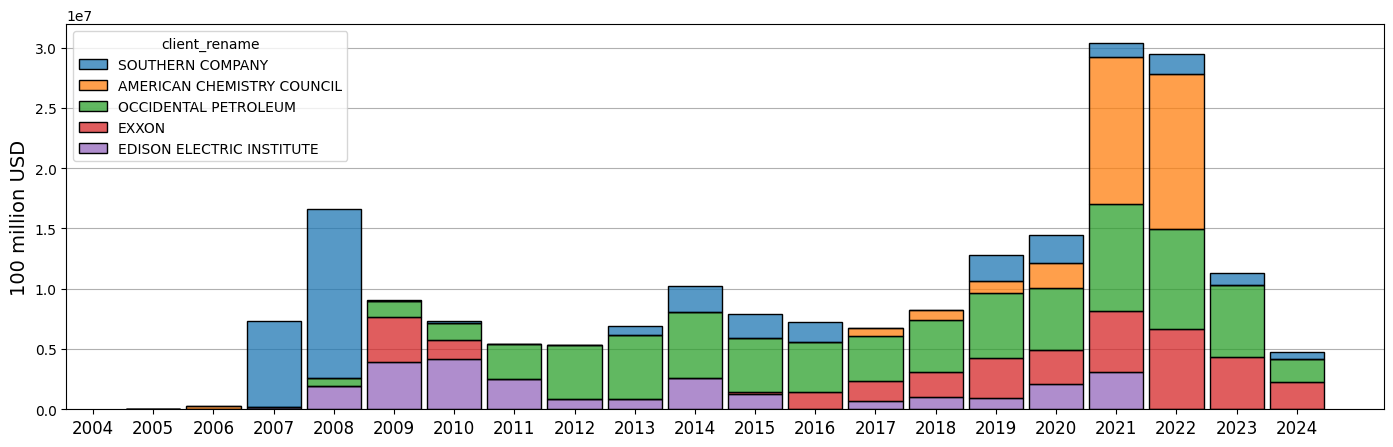

In [47]:
top_10 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXON",
    "AMERICAN CHEMISTRY COUNCIL",
    "EDISON ELECTRIC INSTITUTE",
    "SHELL",
    "CHEVRON",
    "DUKE",
    "BP AMERICA",
    "AMERICAN ELECTRIC POWER",
]
top_3 = ["EXXON", "OCCIDENTAL PETROLEUM", "SOUTHERN COMPANY"]
top_5 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXON",
    "AMERICAN CHEMISTRY COUNCIL",
    "EDISON ELECTRIC INSTITUTE",
]
top_df = (
    df[["lobbying_activity_usd", "n_entities_lobbied", "client_rename", "filing_year"]]
    .loc[(df.very_likely_ccs == 1) & (df.client_rename.isin(top_5))]
    .groupby(["filing_year", "client_rename"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)

years = list(range(2004, 2025))

fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=top_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="client_rename",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")

In [51]:
# top 50 pct companies chart
df[
    [
        "client_rename",
        "sector",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "pct_of_lobbying_dollars",
        "pct_of_entity_contacts",
    ]
].groupby(["client_rename"]).agg(
    {
        "lobbying_activity_usd": sum,
        "n_entities_lobbied": sum,
        "pct_of_lobbying_dollars": sum,
        "pct_of_entity_contacts": sum,
        "sector": "first",
    }
).sort_values(
    by="lobbying_activity_usd", ascending=False
).head(
    16
)  # .to_clipboard()

,lobbying_activity_usd,n_entities_lobbied,pct_of_lobbying_dollars,pct_of_entity_contacts,sector
client_rename,,,,,
OCCIDENTAL PETROLEUM,7.387232e+07,3254,9.675989,5.731295,oil and gas
SOUTHERN COMPANY,3.675466e+07,243,4.814221,0.427998,investor owned utilities
EXXON,3.524051e+07,1072,4.615893,1.888122,oil and gas
AMERICAN CHEMISTRY COUNCIL,2.976511e+07,830,3.898711,1.461885,"chemicals, refining, and plastics"
EDISON ELECTRIC INSTITUTE,2.591875e+07,555,3.394906,0.977526,investor owned utilities
SHELL,1.991873e+07,1401,2.609007,2.467592,oil and gas
CHEVRON,1.882106e+07,912,2.465232,1.606313,oil and gas
DUKE,1.789110e+07,673,2.343423,1.185360,investor owned utilities
BP AMERICA,1.670295e+07,414,2.187796,0.729181,oil and gas


In [52]:
# top sectors chart
df[
    [
        "lumped_sector",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "pct_of_lobbying_dollars",
        "pct_of_entity_contacts",
    ]
].groupby(["lumped_sector"]).agg(
    {
        "lobbying_activity_usd": sum,
        "n_entities_lobbied": sum,
        "pct_of_lobbying_dollars": sum,
        "pct_of_entity_contacts": sum,
    }
).sort_values(
    by="lobbying_activity_usd", ascending=False
).to_clipboard()

In [54]:
df[
    [
        "lumped_sector",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "pct_of_lobbying_dollars",
        "pct_of_entity_contacts",
    ]
].loc[(df.very_likely_ccs == 1) & (df.filing_year > 2018)].sum()

lumped_sector              INVESTOR-OWNED-POWER-SECTORINVESTOR-OWNED-POWE...
lobbying_activity_usd                                       390555044.891471
n_entities_lobbied                                                     27844
pct_of_lobbying_dollars                                            51.155917
pct_of_entity_contacts                                             49.041849
dtype: object

In [55]:
27844 / (260 * 5.5)

19.47132867132867